<a href="https://colab.research.google.com/github/chaurasia-aditya/CaptchaTheBots/blob/main/Resnet50_noise_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from fastai.vision.all import *
import shutil
import os
!pip install py7zr
from py7zr import unpack_7zarchive
from PIL import Image as im
import matplotlib.pyplot as plt
import keras
from keras.datasets import cifar10

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.8/138.8 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 104.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 14.8 MB/s eta 0:00:00


In [2]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


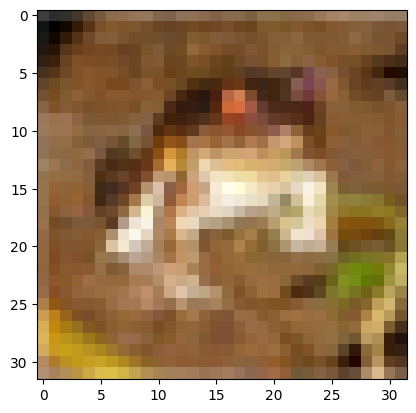

In [3]:
plt.imshow(train_images[0])
plt.show()

In [4]:
label_names = {
    0:'airplane',
    1:'automobile',
    2:'bird',
    3:'cat',
    4:'deer',
    5:'dog',
    6:'frog',
    7:'horse',
    8:'ship',
    9:'truck',
}

<>:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-5-bc99a1d9d01d>:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if i is 0:


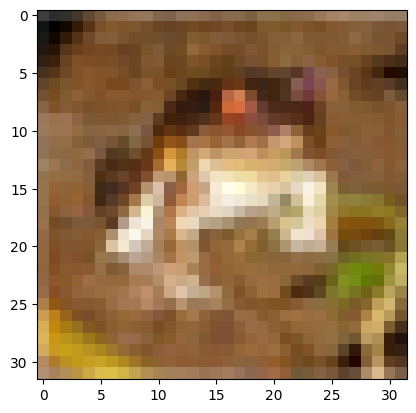

cifar10_dataset/train/frog/0.png


In [5]:
import os
from tensorflow import keras
# Create directories for train and test sets
os.makedirs('cifar10_dataset/train', exist_ok=True)
os.makedirs('cifar10_dataset/test', exist_ok=True)

parent_path_train = "cifar10_dataset/train"
parent_path_valid = "cifar10_dataset/test"

# Organize train images into folders based on labels
for i in range(len(train_images)):
    label = label_names[train_labels[i][0]]
    os.makedirs(f'cifar10_dataset/train/{label}', exist_ok=True)
#     image_filename = f'cifar10_dataset/train/{label}/train_{i}.png'
    image_filename = f'cifar10_dataset/train/{label}/{i}.png'
    if i is 0:
        plt.imshow(train_images[i])
        plt.show()
        print(image_filename)
    keras.preprocessing.image.save_img(image_filename, train_images[i])

# Organize test images into folders based on labels
for i in range(len(test_images)):
    label = label_names[test_labels[i][0]]
    os.makedirs(f'cifar10_dataset/test/{label}', exist_ok=True)
#     image_filename = f'cifar10_dataset/test/{label}/test_{i}.png'
    image_filename = f'cifar10_dataset/test/{label}/{i}.png'
    keras.preprocessing.image.save_img(image_filename, test_images[i])

In [75]:
def noisy(noise_typ,image):
  if noise_typ == "gauss":
    row,col,ch= image.shape
    mean = 0
    var = 100
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    # print(gauss.shape)
    # print(image.shape)
    noisy = image + gauss
    return noisy
  elif noise_typ == "s&p":
    row,col,ch = image.shape
    s_vs_p = 0.5
    amount = 0.0004
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    out[coords] = 1
    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    out[coords] = 0
    return out
  elif noise_typ == "poisson":
      vals = len(np.unique(image))
      vals = 2 ** np.ceil(np.log2(vals))
      noisy = np.random.poisson(image * vals) / float(vals)
      return noisy
  elif noise_typ =="speckle":
      row,col,ch = image.shape
      gauss = np.random.randn(row,col,ch)
      gauss = gauss.reshape(row,col,ch)
      noisy = image + image * gauss
      return noisy

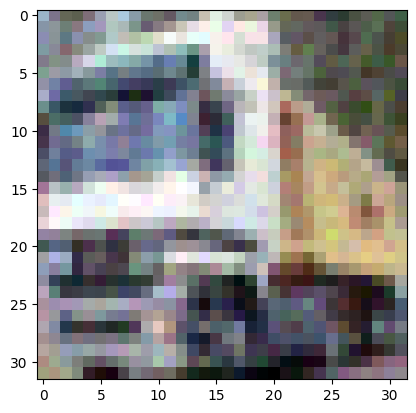

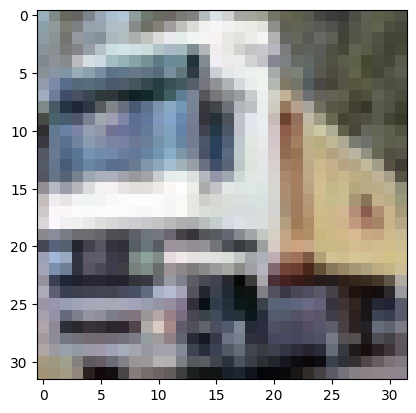

In [76]:
noisy_img = noisy("gauss",train_images[1]*1.0)
# print(noisy_img[0])
# print(train_images[0])
plt.imshow(noisy_img/255.0)
plt.show()
plt.imshow(train_images[1])
plt.show()
# print(image_filename)

#Base

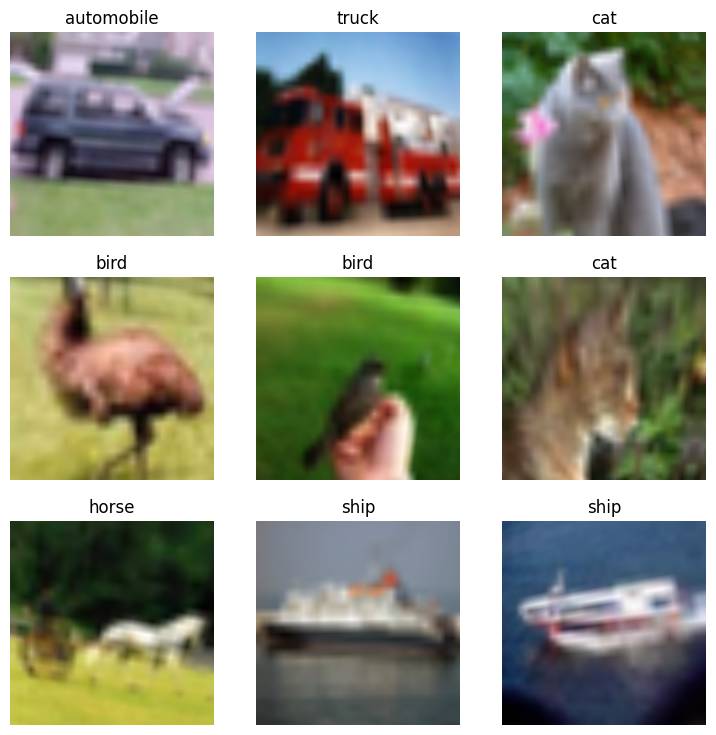

In [91]:
dls = ImageDataLoaders.from_folder(path="./cifar10_dataset", train="train", valid="test", item_tfms=Resize(224), bs=64, batch_tfms=batch_tfms)

dls.show_batch()

In [92]:
# Training the model with resnet101 and MixUp
learn = vision_learner(dls, resnet50, metrics=accuracy, cbs=MixUp())
learn.load("./Resnet50_96.14")

In [93]:
# Validate the model on the validation set and print accuracy
loss, accuracy_val = learn.validate()
print(f"Validation accuracy: {accuracy_val*100:.2f}%")

# learn.recorder.plot_loss()

Validation accuracy: 96.14%


#Gauss

In [94]:
rm -rf ./cifar10_dataset/test_gauss/

In [95]:
os.makedirs('./cifar10_dataset/test_gauss', exist_ok=True)
for i in range(len(test_images)):
    label = label_names[test_labels[i][0]]
    os.makedirs(f'./cifar10_dataset/test_gauss/{label}', exist_ok=True)
#     image_filename = f'cifar10_dataset/test/{label}/test_{i}.png'
    image_filename = f'./cifar10_dataset/test_gauss/{label}/{i}.png'
    noisy_img = noisy("gauss",test_images[i])
    keras.preprocessing.image.save_img(image_filename, noisy_img)

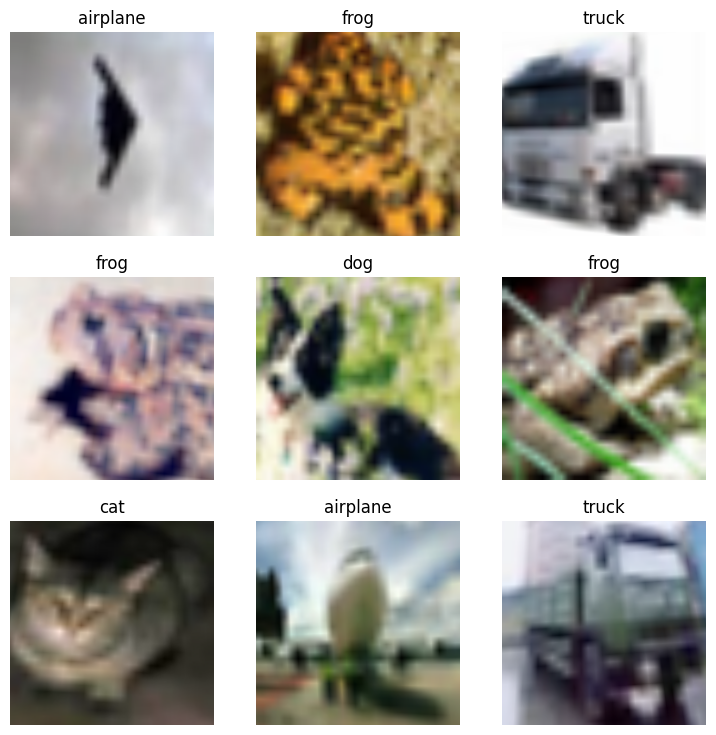

In [96]:
# Data augmentation
batch_tfms = [*aug_transforms(do_flip=True, flip_vert=False, max_rotate=10.0, min_zoom=1.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75), Normalize.from_stats(*imagenet_stats)]
# dls = ImageDataLoaders.from_folder(path="/kaggle/temp", train="train", valid="valid", item_tfms=Resize(224), bs=64, batch_tfms=batch_tfms)
dls2 = ImageDataLoaders.from_folder(path="./cifar10_dataset", train="train", valid="test_gauss", item_tfms=Resize(224), bs=64, batch_tfms=batch_tfms)

dls2.show_batch()

In [97]:
# Training the model with resnet101 and MixUp
learn2 = vision_learner(dls2, resnet50, metrics=accuracy, cbs=MixUp())

In [98]:
learn2.load("./Resnet50_96.14")

In [99]:
# Validate the model on the validation set and print accuracy
loss, accuracy_val = learn2.validate()
print(f"Validation accuracy: {accuracy_val*100:.2f}%")

# learn.recorder.plot_loss()

Validation accuracy: 80.98%


#S&P

In [100]:
!rm -rf ./cifar10_dataset/test_sp/

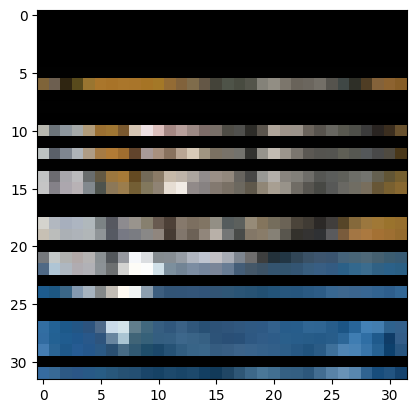

In [101]:
os.makedirs('./cifar10_dataset/test_sp', exist_ok=True)
for i in range(len(test_images)):
    label = label_names[test_labels[i][0]]
    os.makedirs(f'./cifar10_dataset/test_sp/{label}', exist_ok=True)
#     image_filename = f'cifar10_dataset/test/{label}/test_{i}.png'
    image_filename = f'./cifar10_dataset/test_sp/{label}/{i}.png'
    noisy_img = noisy("s&p",test_images[i])
    if i == 0:
      plt.imshow(noisy_img/255.0)
      plt.show()
      # print(noisy_img[1])
    keras.preprocessing.image.save_img(image_filename, noisy_img)

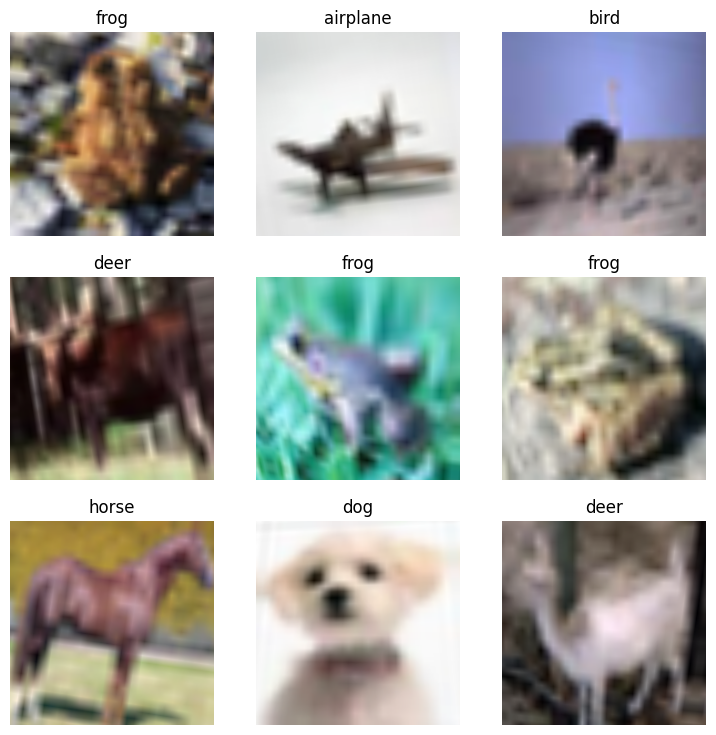

In [102]:
dls3 = ImageDataLoaders.from_folder(path="./cifar10_dataset", train="train", valid="test_sp", item_tfms=Resize(224), bs=64, batch_tfms=batch_tfms)

dls3.show_batch()

In [103]:
# Training the model with resnet101 and MixUp
learn3 = vision_learner(dls3, resnet50, metrics=accuracy, cbs=MixUp())
learn3.load("./Resnet50_96.14")

In [104]:
# Validate the model on the validation set and print accuracy
loss, accuracy_val = learn3.validate()
print(f"Validation accuracy: {accuracy_val*100:.2f}%")

# learn.recorder.plot_loss()

Validation accuracy: 17.35%


#Poisson

In [105]:
!rm -rf ./cifar10_dataset/test_poi

In [106]:
os.makedirs('./cifar10_dataset/test_poi', exist_ok=True)
for i in range(len(test_images)):
    label = label_names[test_labels[i][0]]
    os.makedirs(f'./cifar10_dataset/test_poi/{label}', exist_ok=True)
#     image_filename = f'cifar10_dataset/test/{label}/test_{i}.png'
    image_filename = f'./cifar10_dataset/test_poi/{label}/{i}.png'
    noisy_img = noisy("poisson",test_images[i])
    keras.preprocessing.image.save_img(image_filename, noisy_img)

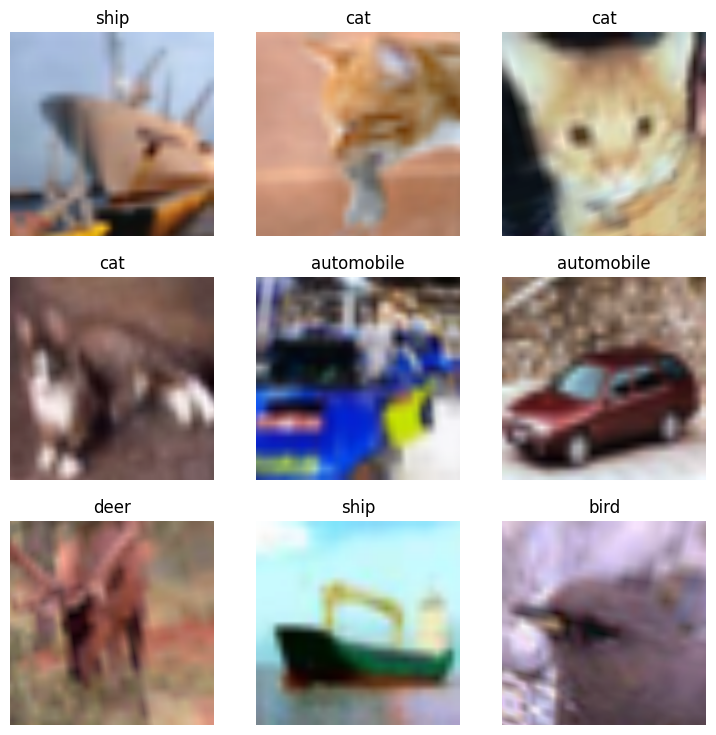

In [107]:
dls4 = ImageDataLoaders.from_folder(path="./cifar10_dataset", train="train", valid="test_poi", item_tfms=Resize(224), bs=64, batch_tfms=batch_tfms)

dls4.show_batch()

In [108]:
# Training the model with resnet101 and MixUp
learn4 = vision_learner(dls4, resnet50, metrics=accuracy, cbs=MixUp())
learn4.load("./Resnet50_96.14")

In [109]:
loss, accuracy_val = learn4.validate()
print(f"Validation accuracy: {accuracy_val*100:.2f}%")

Validation accuracy: 96.06%


#Speckle

In [110]:
os.makedirs('./cifar10_dataset/test_speck', exist_ok=True)
for i in range(len(test_images)):
    label = label_names[test_labels[i][0]]
    os.makedirs(f'./cifar10_dataset/test_speck/{label}', exist_ok=True)
#     image_filename = f'cifar10_dataset/test/{label}/test_{i}.png'
    image_filename = f'./cifar10_dataset/test_speck/{label}/{i}.png'
    noisy_img = noisy("poisson",test_images[i])
    keras.preprocessing.image.save_img(image_filename, noisy_img)

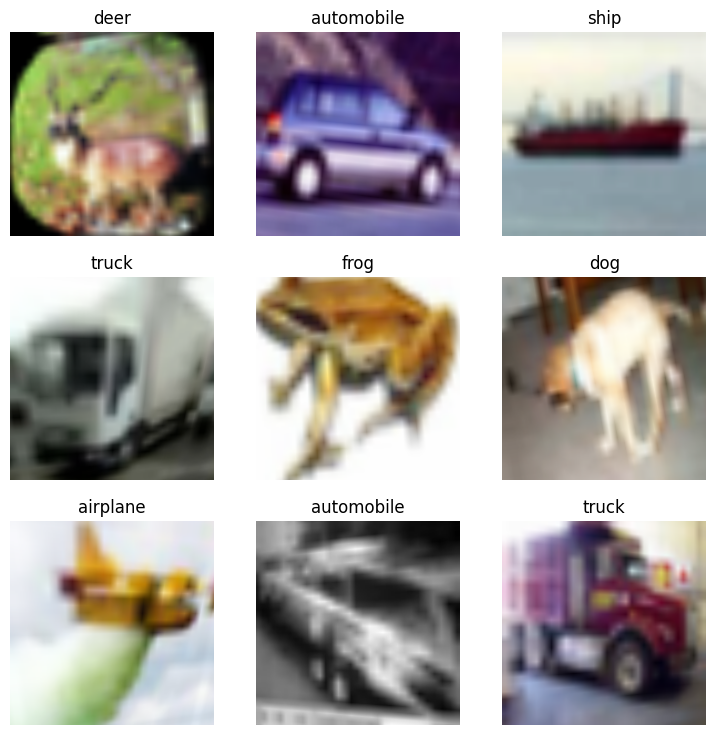

In [111]:
dls5 = ImageDataLoaders.from_folder(path="./cifar10_dataset", train="train", valid="test_speck", item_tfms=Resize(224), bs=64, batch_tfms=batch_tfms)
dls5.show_batch()

In [112]:
# Training the model with resnet101 and MixUp
learn5 = vision_learner(dls4, resnet50, metrics=accuracy, cbs=MixUp())
learn5.load("./Resnet50_96.14")

In [113]:
loss, accuracy_val = learn5.validate()
print(f"Validation accuracy: {accuracy_val*100:.2f}%")

Validation accuracy: 96.06%


#S&P 2

In [122]:
!rm -rf ./cifar10_dataset/test_sp2/

In [123]:
noise_factor = 0.01

from skimage.util import random_noise

#noisy = random_noise(img, mode="poisson")
#just change the mode pf the noise to-->'gaussain',
test_images_sp = random_noise(test_images, mode="s&p",clip=True, amount=noise_factor)

In [124]:
os.makedirs('./cifar10_dataset/test_sp2', exist_ok=True)
for i in range(len(test_images)):
    label = label_names[test_labels[i][0]]
    os.makedirs(f'./cifar10_dataset/test_sp2/{label}', exist_ok=True)
#     image_filename = f'cifar10_dataset/test/{label}/test_{i}.png'
    image_filename = f'./cifar10_dataset/test_sp2/{label}/{i}.png'
    # noisy_img = add_sp(test_images[i])
    # if i == 0:
    #   plt.imshow(noisy_img/255.0)
    #   plt.show()
    #   # print(noisy_img[1])
    keras.preprocessing.image.save_img(image_filename, test_images_sp[i])

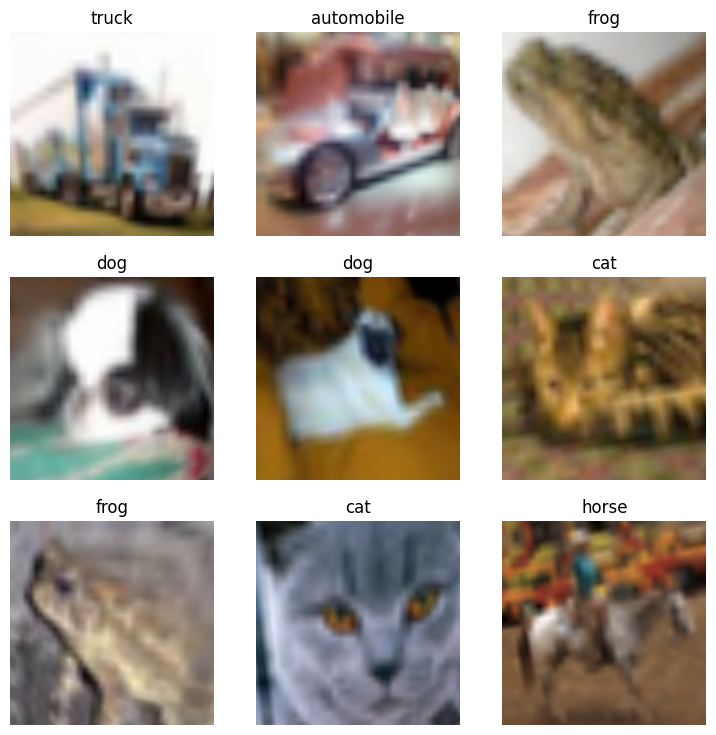

In [125]:
dls6 = ImageDataLoaders.from_folder(path="./cifar10_dataset", train="train", valid="test_sp2", item_tfms=Resize(224), bs=64, batch_tfms=batch_tfms)
dls6.show_batch()

In [126]:
# Training the model with resnet101 and MixUp
learn6 = vision_learner(dls6, resnet50, metrics=accuracy, cbs=MixUp())
learn6.load("./Resnet50_96.14")

In [127]:
loss, accuracy_val = learn6.validate()
print(f"Validation accuracy: {accuracy_val*100:.2f}%")

Validation accuracy: 76.91%


#GAUSSIAN 2

In [130]:
!rm -rf ./cifar10_dataset/test_g2

In [129]:
noise_factor = 0.01

from skimage.util import random_noise

#noisy = random_noise(img, mode="poisson")
#just change the mode pf the noise to-->'gaussain',
test_images_g = random_noise(test_images, mode="gaussian",clip=True, mean=0, var=10)

In [131]:
os.makedirs('./cifar10_dataset/test_g2', exist_ok=True)
for i in range(len(test_images)):
    label = label_names[test_labels[i][0]]
    os.makedirs(f'./cifar10_dataset/test_g2/{label}', exist_ok=True)
    image_filename = f'./cifar10_dataset/test_g2/{label}/{i}.png'
    keras.preprocessing.image.save_img(image_filename, test_images_g[i])

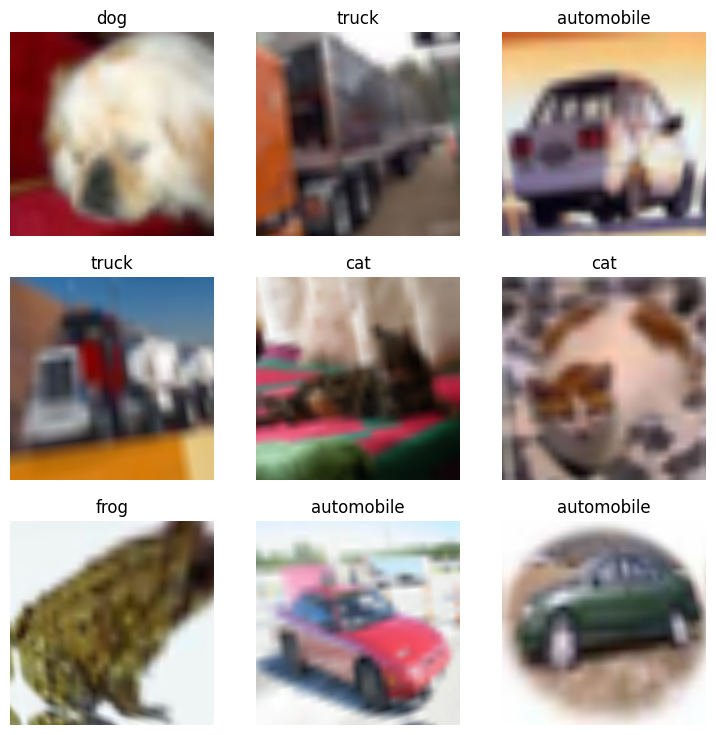

In [132]:
dls7 = ImageDataLoaders.from_folder(path="./cifar10_dataset", train="train", valid="test_g2", item_tfms=Resize(224), bs=64, batch_tfms=batch_tfms)
dls7.show_batch()

In [133]:
# Training the model with resnet101 and MixUp
learn7 = vision_learner(dls7, resnet50, metrics=accuracy, cbs=MixUp())
learn7.load("./Resnet50_96.14")

In [134]:
loss, accuracy_val = learn7.validate()
print(f"Validation accuracy: {accuracy_val*100:.2f}%")

Validation accuracy: 10.51%


#Poisson2

In [136]:
!rm -rf ./cifar10_dataset/test_poi2

In [135]:
noise_factor = 0.01

from skimage.util import random_noise

#noisy = random_noise(img, mode="poisson")
#just change the mode pf the noise to-->'gaussain',
test_images_p = random_noise(test_images, mode="poisson",clip=True)

In [137]:
os.makedirs('./cifar10_dataset/test_p2', exist_ok=True)
for i in range(len(test_images)):
    label = label_names[test_labels[i][0]]
    os.makedirs(f'./cifar10_dataset/test_p2/{label}', exist_ok=True)
    image_filename = f'./cifar10_dataset/test_p2/{label}/{i}.png'
    keras.preprocessing.image.save_img(image_filename, test_images_p[i])

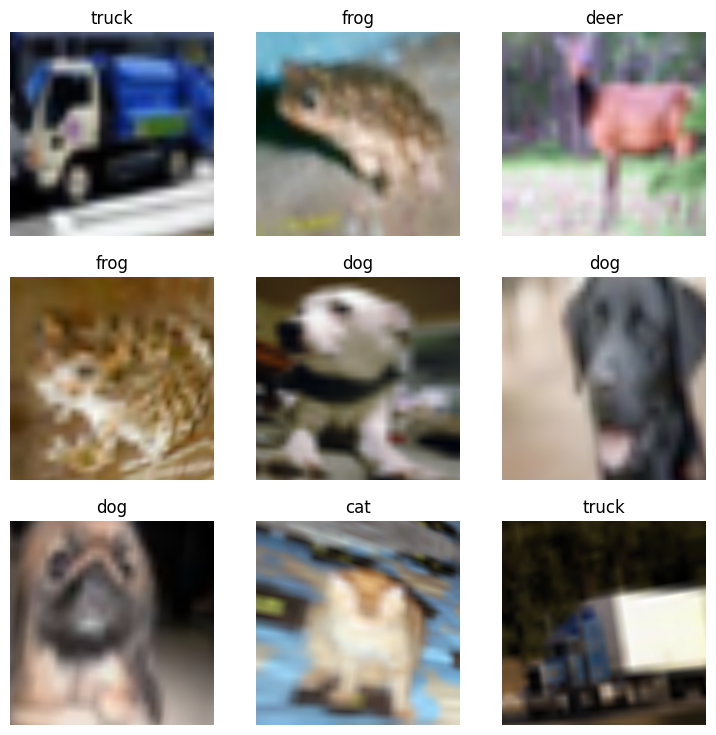

In [138]:
dls8 = ImageDataLoaders.from_folder(path="./cifar10_dataset", train="train", valid="test_p2", item_tfms=Resize(224), bs=64, batch_tfms=batch_tfms)
dls8.show_batch()

In [139]:
# Training the model with resnet101 and MixUp
learn8 = vision_learner(dls8, resnet50, metrics=accuracy, cbs=MixUp())
learn8.load("./Resnet50_96.14")

In [140]:
loss, accuracy_val = learn8.validate()
print(f"Validation accuracy: {accuracy_val*100:.2f}%")

Validation accuracy: 79.02%
